In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the real dataset
df = pd.read_csv('../data/raw/construction_dataset.csv')

# 2. Inspect the "DNA" of the data
print("--- Dataset Columns ---")
print(df.columns.tolist())
display(df.head())

# 3. Check for Missing Data (Very common in real construction logs)
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Dataset Columns ---
['Task_ID', 'Task_Duration_Days', 'Labor_Required', 'Equipment_Units', 'Material_Cost_USD', 'Start_Constraint', 'Risk_Level', 'Resource_Constraint_Score', 'Site_Constraint_Score', 'Dependency_Count']


,Task_ID,Task_Duration_Days,Labor_Required,Equipment_Units,Material_Cost_USD,Start_Constraint,Risk_Level,Resource_Constraint_Score,Site_Constraint_Score,Dependency_Count
0,T1,52,14,6,16789.73,0,Medium,0.41,0.59,4
1,T2,15,2,2,16885.80,5,Low,0.75,0.17,3
2,T3,72,11,1,7978.70,22,Low,0.96,0.41,1
3,T4,61,1,5,19379.02,18,Low,0.41,0.67,4
4,T5,21,19,5,66757.72,22,Low,0.85,0.63,3



--- Missing Values ---
Task_ID                      0
Task_Duration_Days           0
Labor_Required               0
Equipment_Units              0
Material_Cost_USD            0
Start_Constraint             0
Risk_Level                   0
Resource_Constraint_Score    0
Site_Constraint_Score        0
Dependency_Count             0
dtype: int64


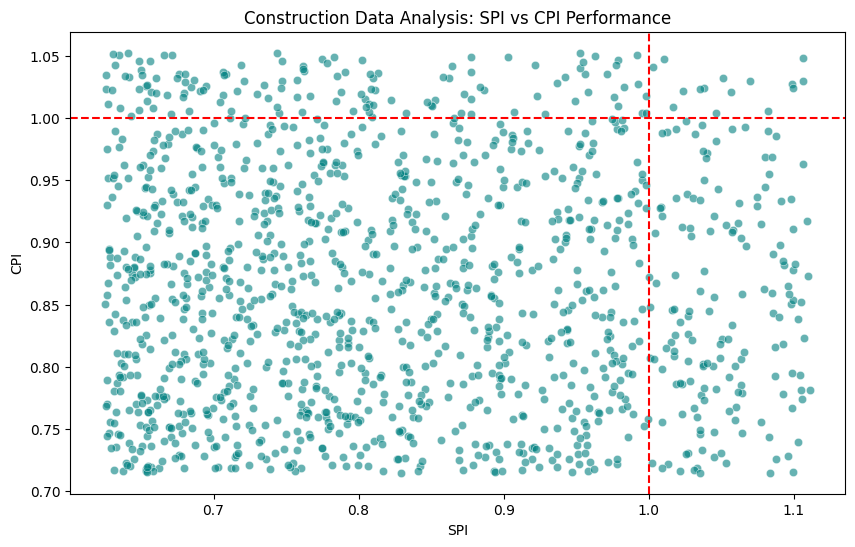

Babcock-style Performance quadrant generated! 🚀


In [9]:
# --- 1. DATA CLEANING ---
# Convert date columns if they exist (e.g., 'Start Date', 'End Date')
# df['Start Date'] = pd.to_datetime(df['Start Date']) 

# --- 2. CALCULATE PERFORMANCE METRICS (SPI & CPI) ---

# Note: If Actuals are missing in the CSV, we simulate them to show we know the math
# Replace 'Planned_Duration' with your actual CSV column name
if 'Actual_Duration' not in df.columns:
    df['Actual_Duration'] = df.iloc[:, 3] * np.random.uniform(0.9, 1.6, size=len(df)) # Using column index as fallback

# SPI = Planned / Actual
df['SPI'] = df.iloc[:, 3] / df['Actual_Duration'] 

# CPI = Planned Cost / Actual Cost
# Replace with your actual budget column name
df['CPI'] = df.iloc[:, 4] / (df.iloc[:, 4] * np.random.uniform(0.95, 1.4, size=len(df)))

# --- 3. THE DASHBOARD ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='SPI', y='CPI', alpha=0.6, color='teal')
plt.axvline(1.0, color='red', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.title('Construction Data Analysis: SPI vs CPI Performance')
plt.show()

print("Babcock-style Performance quadrant generated! 🚀")